In [1]:
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

# from utils import global_convexity_violation_holm
from utils import global_convexity_violation
from meta_feature import dataset_ids_CC18, anchor_list_denser, learner_zoo, learner_zoo_abbreviation

In [2]:
file_paths = Path.cwd() / '../dataset/LCDB11_ER_CC18_compress.hdf5'
dataset_CC18 = h5py.File(file_paths , 'r')['error rate'][...] 
dataset_nofs, dataset_minmaxfs, dataset_standardfs = dataset_CC18[..., 0, 0], dataset_CC18[..., 1, 0], dataset_CC18[..., 2, 0]

In [3]:
conv_matrix_nofs, conv_h_matrix_nofs, conv_i_matrix_nofs, conv_j_matrix_nofs = global_convexity_violation(dataset_nofs)
conv_matrix_minmaxfs, conv_h_matrix_minmaxfs, conv_i_matrix_minmaxfs, conv_j_matrix_minmaxfs = global_convexity_violation(dataset_minmaxfs)
conv_matrix_standardfs, conv_h_matrix_standardfs, conv_i_matrix_standardfs, conv_j_matrix_standardfs = global_convexity_violation(dataset_standardfs)

100%|██████████| 72/72 [01:58<00:00,  1.65s/it]


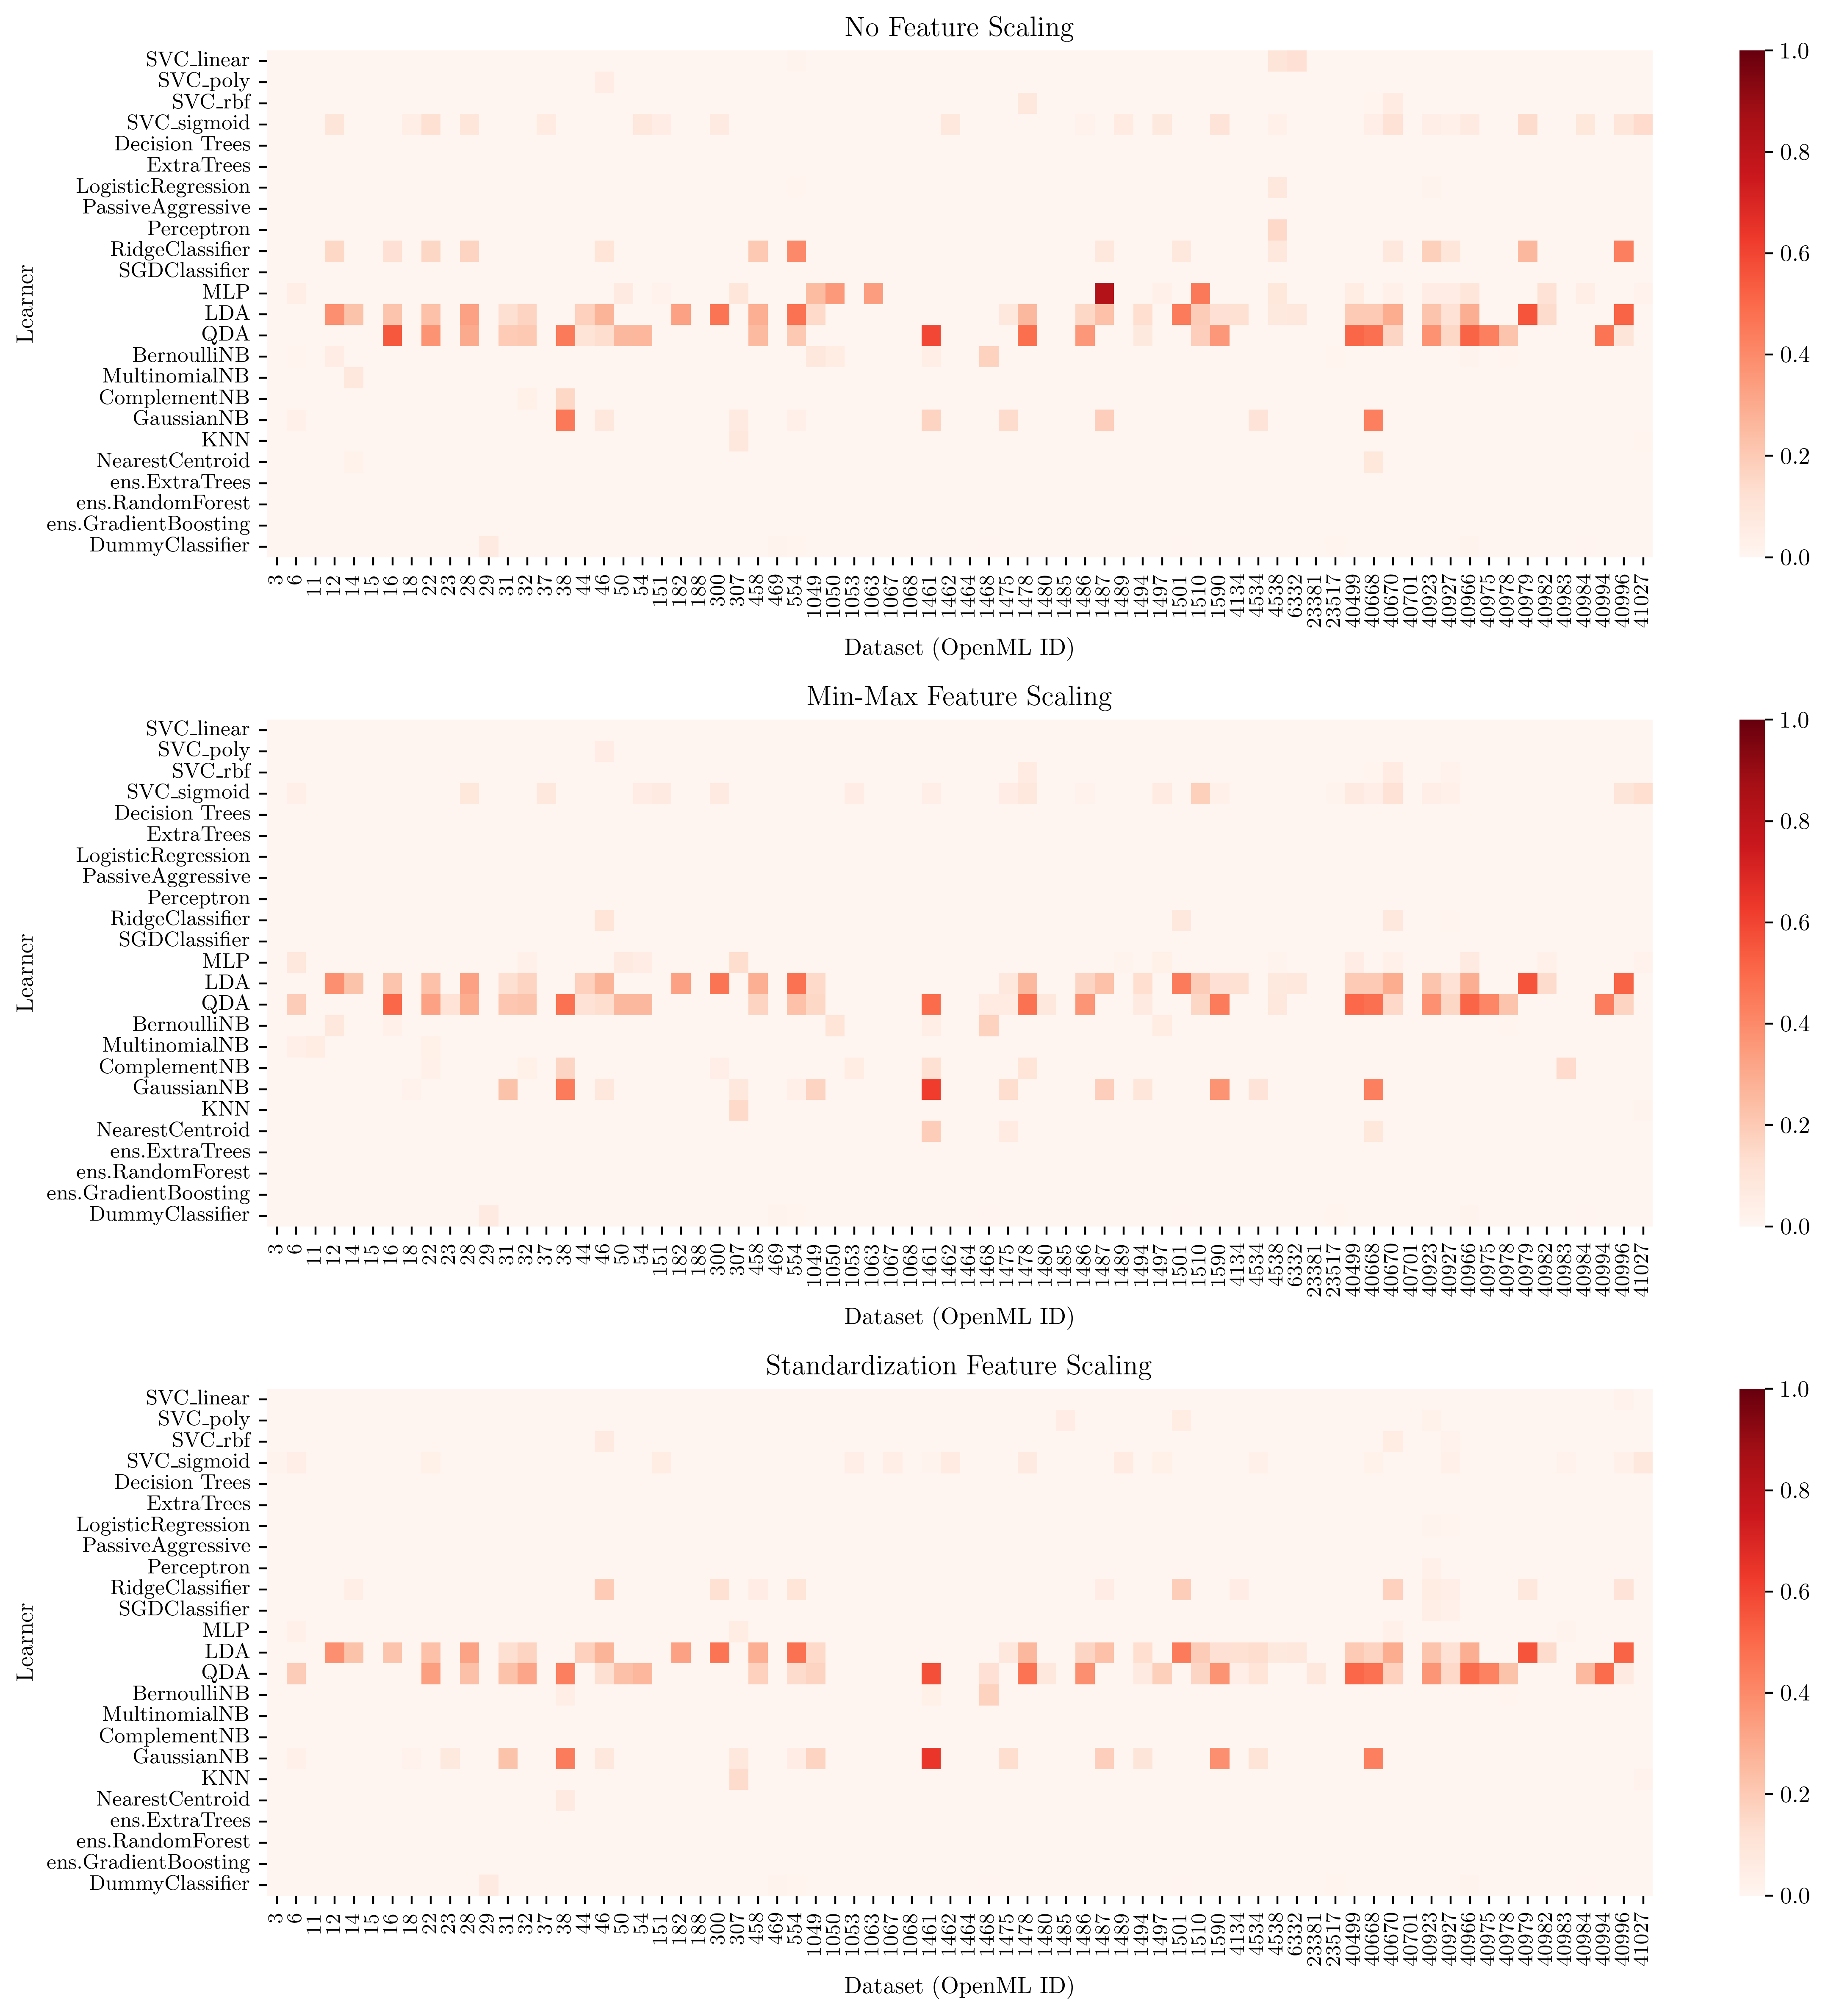

In [4]:
conv_matrices = [conv_matrix_nofs, conv_matrix_minmaxfs, conv_matrix_standardfs]
titles = ['No Feature Scaling', 'Min-Max Feature Scaling', 'Standardization Feature Scaling']

fig, axes = plt.subplots(3, 1, figsize=(12, 12), dpi=400) 

for ax, matrix, title in zip(axes, conv_matrices, titles):
    sns.heatmap(matrix, ax=ax, cmap="Reds", annot=False, cbar=True, vmin=0, vmax=1)
    ax.set_title(title)
    ax.set_yticks([y + 0.5 for y in range(len(learner_zoo))])
    ax.set_yticklabels(learner_zoo, rotation=0, fontsize=9)
    ax.set_xticks([x + 0.5 for x in range(len(dataset_ids_CC18))])
    ax.set_xticklabels(dataset_ids_CC18, rotation=90, fontsize=9)
    ax.set_xlabel('Dataset (OpenML ID)')
    ax.set_ylabel('Learner')

plt.tight_layout()
plt.show()


In [5]:
percentages_nofs = (np.sum(conv_matrix_nofs > 0, axis=1) / conv_matrix_nofs.shape[1]) * 100
percentages_minmaxfs = (np.sum(conv_matrix_minmaxfs > 0, axis=1) / conv_matrix_minmaxfs.shape[1]) * 100
percentages_standardfs = (np.sum(conv_matrix_standardfs > 0, axis=1) / conv_matrix_standardfs.shape[1]) * 100


# filter some learner
exclude_indices = [13, 23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo_abbreviation) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

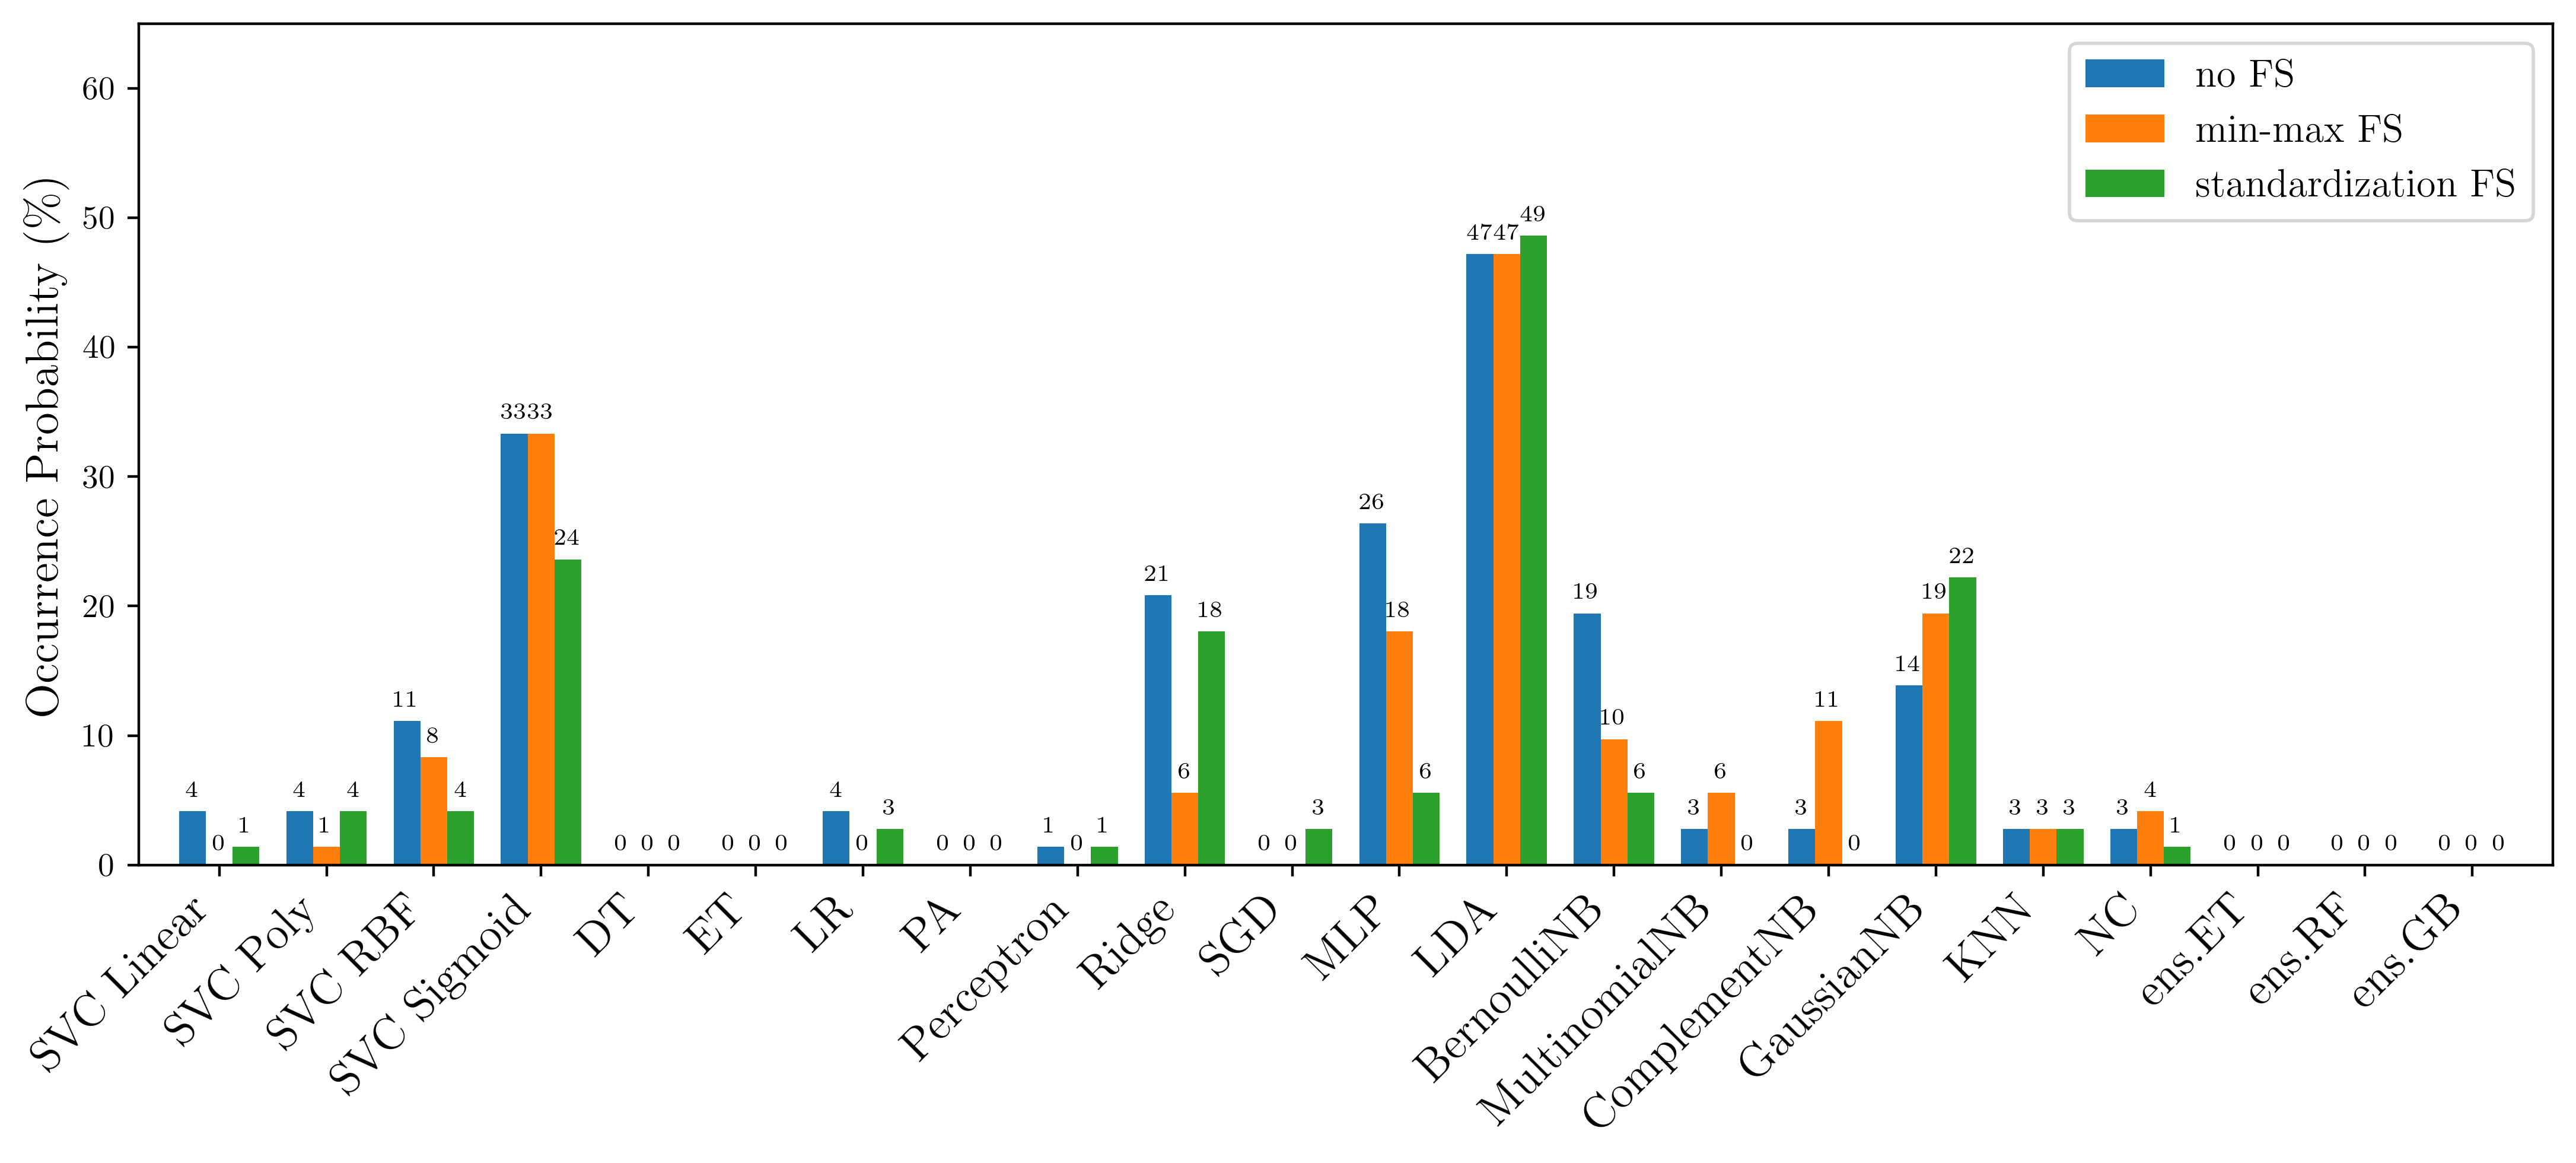

In [6]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Occurrence Probability (\%)', fontsize = 14)
ax.set_ylim(0,65)
ax.set_xticks(x)
ax.set_xlim(x[0] - 3 * width, x[-1] + 3 * width)    # set tighter x-axis limits
ax.set_xticklabels(learner_zoo_filtered, rotation=45, ha='right', fontsize = 14)  
ax.legend(fontsize = 12)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


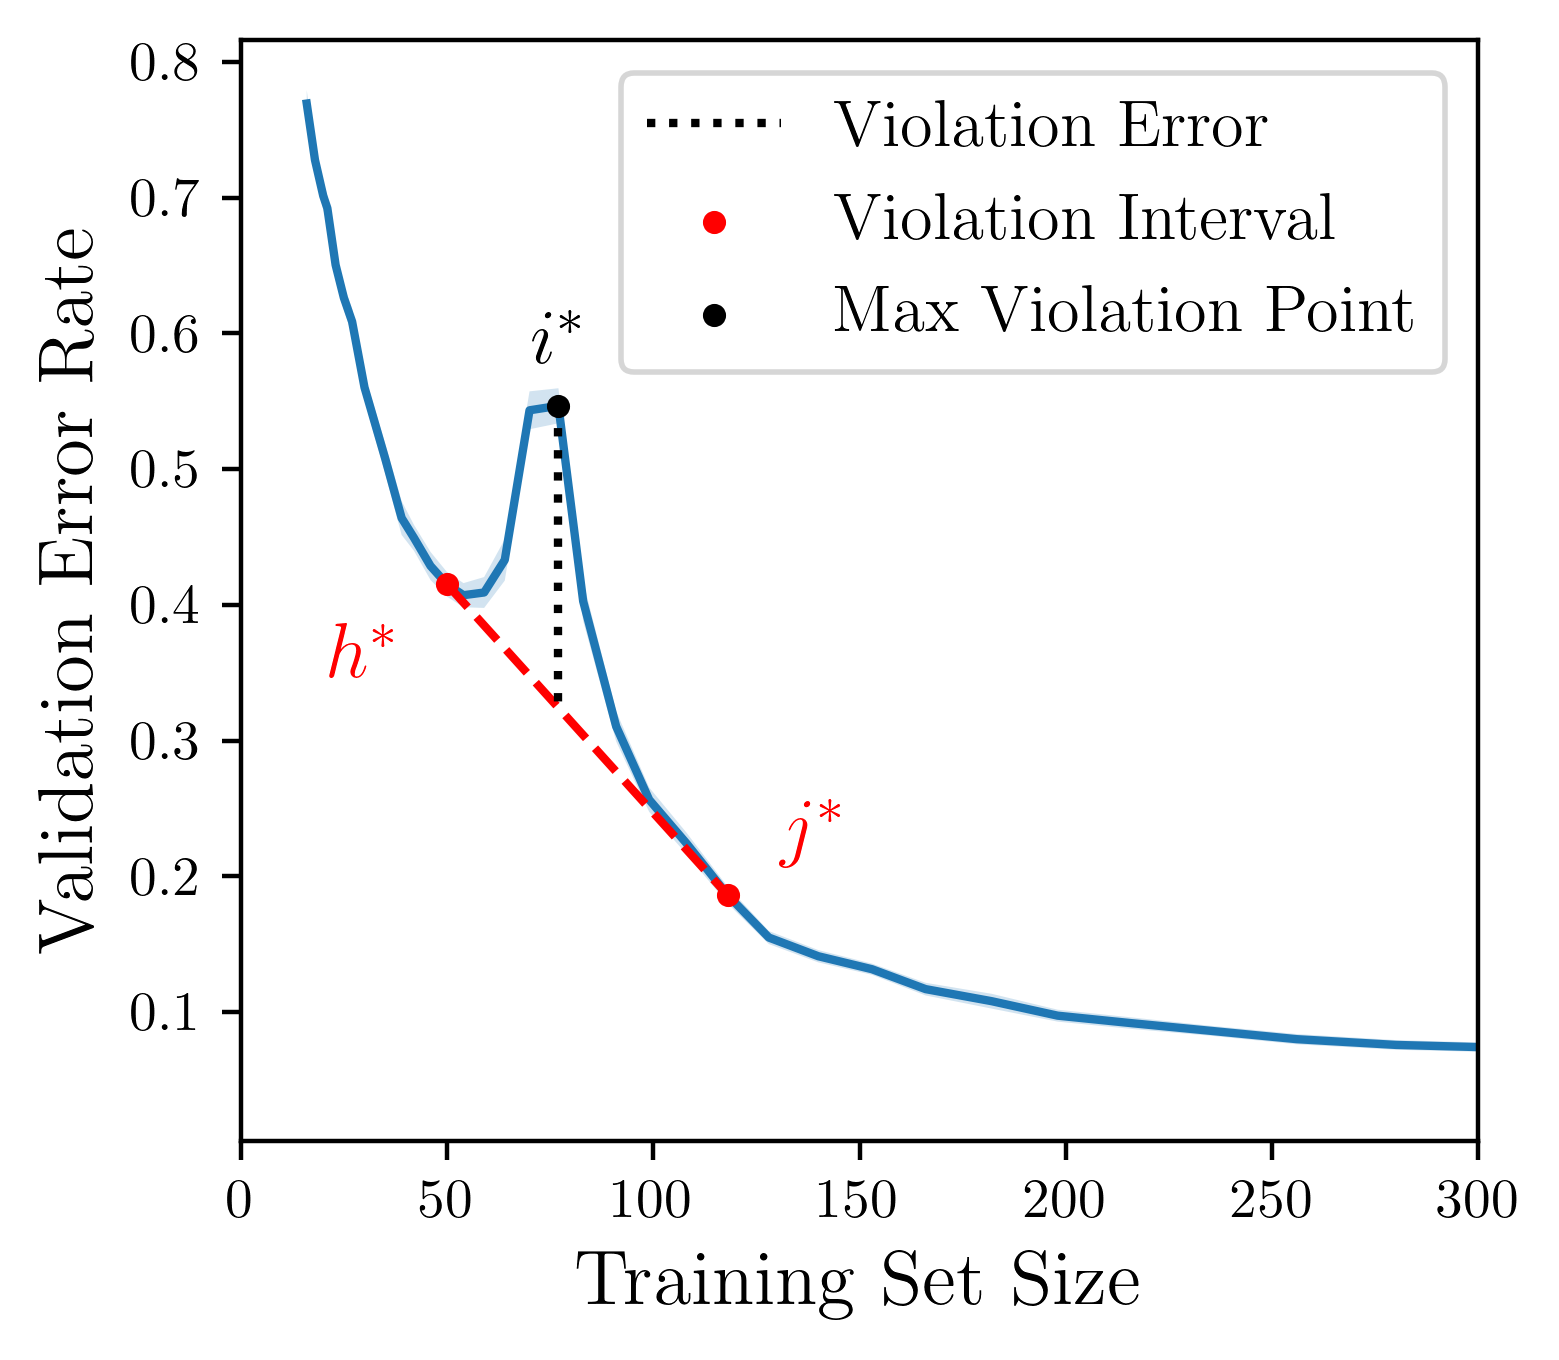

In [7]:
LEARNER, DATASET = 12, 6

lc_clean = dataset_nofs[DATASET, LEARNER, :, :, :, 1]
mean_clean = np.nanmean(lc_clean[:, :, :], axis=(0, 1))
se_clean = np.nanstd(lc_clean[:, :, :], axis=(0, 1), ddof=1) / np.sqrt(np.sum(~np.isnan(lc_clean[:, :, :]), axis=(0, 1)))

plt.figure(figsize=(4, 3.5), dpi=400)
plt.plot(anchor_list_denser, mean_clean)#, label="LCDB 1.1 noFS")
plt.fill_between(anchor_list_denser, mean_clean - se_clean, mean_clean + se_clean, alpha=0.2)

num_points = len(mean_clean)
triple_indices = [(h, i, j) for h in range(num_points - 2) 
                    for i in range(h + 1, num_points - 1) 
                    for j in range(i + 1, num_points)]

# find maximum convexity violation i
max_violation = 0 
h_index, i_index, j_index = None, None, None

# loop all (h, i, j)
for (h, i, j) in triple_indices:
    # mid point
    uneven_ratio_j = (anchor_list_denser[i] - anchor_list_denser[h]) / (anchor_list_denser[j] - anchor_list_denser[h]) 
    uneven_ratio_h = (anchor_list_denser[j] - anchor_list_denser[i]) / (anchor_list_denser[j] - anchor_list_denser[h])
    mid_point_hj = mean_clean[h] * uneven_ratio_h + mean_clean[j] * uneven_ratio_j 
    # diff
    violation = mean_clean[i] - mid_point_hj

    if violation > max_violation:
        max_violation = violation
        h_index, i_index, j_index = h, i, j

if i_index is not None and j_index is not None:
    x1, x2 = anchor_list_denser[h_index], anchor_list_denser[j_index]
    y1, y2 = mean_clean[h_index], mean_clean[j_index]
    x_, y_ = anchor_list_denser[i_index], mean_clean[i_index]

    # h* and j* 
    plt.plot([x1, x2], [y1, y2], 'r--', linewidth=1.5, zorder=4)
    # violation error
    plt.vlines(x_, ymin=y_, ymax=(y1*(x2-x_)/(x2-x1)+y2*(x_-x1)/(x2-x1)), colors='black', linestyles='dotted', linewidth=1.5, zorder=4, label = 'Violation Error')

    plt.scatter([x1, x2], [y1, y2], color='red', s=10, zorder=5, label = 'Violation Interval')  
    plt.scatter(x_, y_, color='black', s=10, zorder=5, label = 'Max Violation Point')  

    plt.text(x1-20, y1-0.08, '$h^*$', fontsize=14, ha='center', va='bottom', color='red')  
    plt.text(x2+20, y2 + 0.02, '$j^*$', fontsize=14, ha='center', va='bottom', color='red')
    plt.text(x_, y_ +0.02, '$i^*$', fontsize=14, ha='center', va='bottom', color='black')

plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Validation Error Rate', fontsize=14)
plt.xlim(0,300)
# plt.xscale('log')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
